In [3]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import asyncio
from time import time
from collections import defaultdict
import operator

data = pd.read_pickle('data.pkl.gz')
hospitalization = pd.read_pickle('hospitalization.pkl.gz')

In [4]:
data

name age_distribution                      \
                                                    0         5        10   
BR-AC                           Acre            83212     84343     87619   
BR-AL                        Alagoas           250898    256877    274339   
BR-AM                       Amazonas           403991    408396    398691   
BR-AP                          Amapá            79737     80979     81326   
BR-BA                          Bahia          1022457   1023232   1090291   
BR-CE                          Ceará           654983    644552    666500   
BR-DF               Distrito Federal           206217    191098    200424   
BR-ES                 Espírito Santo           288258    285958    274012   
BR-GO                          Goiás           516396    525211    498076   
BR-MA                       Maranhão           586847    579924    635958   
BR-MG                   Minas Gerais          1327260   1325742   1323037   
BR-MS             Mato Grosso do Sul           219254    218035    204162   
BR-MT                    Mato Grosso           284177    274519    262494   
BR-PA                           Pará           718039    723937    772977   
BR-PB                        Paraíba           285356    273516    294410   
BR-PE                     Pernambuco           683032    702226    720604   
BR-PI                          Piauí           236708    234741    250065   
BR-PR                         Paraná           787917    776684    746530   
BR-RJ                 Rio de Janeiro          1122003   1111248   1053319   
BR-RN            Rio Grande do Norte           237004    243311    253629   
BR-RO                       Rondônia           140422    137136    135190   
BR-RR                        Roraima            60911     56319     54586   
BR-RS              Rio Grande do Sul           702550    704967    662705   
BR-SC                 Santa Catarina           487335    473066    446306   
BR-SE                        Sergipe           169912    170197    176894   
BR-SP                      São Paulo          3022050   3058550   2953372   
BR-TO                      Tocantins           126411    124664    129695   
BR-1100205     Porto Velho (capital)            42093     41280     40098   
BR-1200401      Rio Branco (capital)            30728     32722     35605   
BR-1302603          Manaus (capital)           172339    181624    185779   
BR-1400100       Boa Vista (capital)            34523     32757     32134   
BR-1501402           Belém (capital)            68473     75725     94081   
BR-1600303          Macapá (capital)            43315     45255     46440   
BR-1721000          Palmas (capital)            30741     30629     29590   
BR-2111300        São Luís (capital)            61600     66861     79703   
BR-2211001        Teresina (capital)              896       828       816   
BR-2304400       Fortaleza (capital)           161059    163014    174254   
BR-2408102           Natal (capital)            49133     52193     56386   
BR-2507507     João Pessoa (capital)            53138     52087     56719   
BR-2611606          Recife (capital)            85426     90920     99939   
BR-2704302          Maceió (capital)            64454     67690     75933   
BR-2800308         Aracaju (capital)            41887     44211     47232   
BR-2927408        Salvador (capital)           146177    151655    170796   
BR-3106200  Belo Horizonte (capital)           126242    128858    131259   
BR-3205309         Vitória (capital)            22207     22939     22514   
BR-3304557  Rio de Janeiro (capital)           388822    389518    376910   
BR-3550308       São Paulo (capital)           756843    767047    746620   
BR-4106902        Curitiba (capital)           115943    117175    114219   
BR-4205407   Florianópolis (capital)            28147     28326     26739   
BR-4314902    Porto Alegre (capital)            84201     85436     79832   
BR-5002704    Campo Grande (

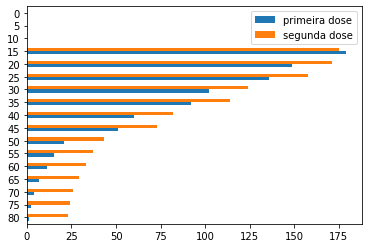

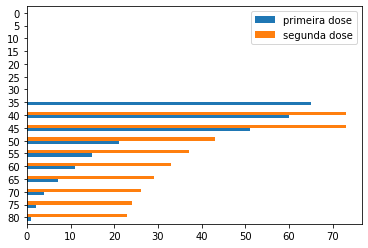

In [5]:
class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def start(self):
        self._task = asyncio.ensure_future(self._job())

    def cancel(self):
        self._task.cancel()


def debounce(wait):
    """ Decorator that will postpone a function's
        execution until after `wait` seconds
        have elapsed since the last time it was invoked. """
    def decorator(fn):
        timer = None
        def debounced(*args, **kwargs):
            nonlocal timer
            def call_it():
                fn(*args, **kwargs)
            if timer is not None:
                timer.cancel()
            timer = Timer(wait, call_it)
            timer.start()
        return debounced
    return decorator


def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled, timer = False, None
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled, timer
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args, new_kwargs = args, kwargs
            if not scheduled:
                scheduled = True
                new_wait = max(0, wait - time_since_last_call)
                timer = Timer(new_wait, call_it)
                timer.start()
        return throttled
    return decorator


def label(label, widget):
    return widgets.VBox([widgets.Label(label + ': '), widget])


def form(labels):
    return widgets.VBox([label(k, v) for k, v in labels.items()])


def population_80_plus(data):
    data.loc[80] = data.loc[80:].sum()
    return data.loc[:80].iloc[::-1]

    
def vaccination_policy(population, rate, target_rate=1.0, initial=None, duration=365, 
                       delay=22, short=False, normalize=False, stock=None):
    
    index = population.index
    population = np.asarray(population)
    nbins = len(population)
        
    if isinstance(target_rate, (float)):
        target_rate = np.array([target_rate] * nbins)
    else:
        target_rate = np.asarray(target_rate)
    target = population * target_rate

    curves = []
    schedule = defaultdict(dict)
    idx = 0
    
    curr = np.array([[0, 0]] * nbins)
    if initial is not None:
        if np.ndim(initial) == 1:
            curr[:, 0] = initial
        else:
            curr[:] = initial

    for day in range(duration):
        stock = rate

        if day in schedule:
            for k, v in schedule.pop(day).items():
                curr[k, 1] += v
                stock -= v

        missing = target[idx] - curr[idx, 0]
        if missing > stock:
            curr[idx, 0] += stock
            schedule[day + delay][idx] = stock

        else:
            curr[idx, 0] = target[idx]
            schedule[day + delay][idx] = missing

            remain = stock - missing
            if idx + 1 < len(target):
                curr[idx + 1, 0] += remain
                schedule[day + delay][idx + 1] = remain

            idx += 1
            if idx == len(target):
                if short:
                    break
                idx -= 1

        curves.append(curr.copy().T)

    curves = np.array(curves)
    normalization = population if normalize else 1
    return pd.concat({
        'first': pd.DataFrame(curves[:, 0, :] / normalization, columns=index),
        'second': pd.DataFrame(curves[:, 1, :] / normalization, columns=index),
    }, axis=1)


def alias(prop):
    owner, attr = prop.split('.')
    return property(
        operator.attrgetter(prop),
        lambda self, x: setattr(getattr(self, owner), attr, x)
    )


def vaccination_day(curve):
    return pd.Series(
        np.argmax((curve == curve.max()).values, axis=0),
        index=curve.columns,
    )

class UI:
    region = alias('_region.value')
    rate = alias('_rate.value')
    vaccines = alias('_vaccines.value')
    second_dose_delay = alias('_second_dose_delay.value')
    immunization_delay = alias('_immunization_delay.value')
    duration = alias('_duration.value')
    vaccination_ratio = alias('_vaccination_ratio.value')
        
    def __init__(self, data):
        self.data = data
        self.vaccine_curve = None
        self.death_rate = None
        
        options = [(v, k) for k, v in data['name'].to_dict().items()]
        self._region = widgets.Dropdown(options=options)
        # self._capacity = widgets.FloatLogSlider(6_000, max=7, readout_format='.0f')
        self._rate = widgets.IntText(6_000)
        # self._vaccines = widgets.FloatLogSlider(2000_000, max=9, readout_format='.0f')
        self._vaccines = widgets.IntText(1_500_000)
        self._second_dose_delay = widgets.IntSlider(22, min=1, max=100)
        self._immunization_delay = widgets.IntSlider(20, min=1, max=100)
        self._duration = widgets.IntSlider(180, 10, 365)
        self._vaccination_ratio = widgets.FloatSlider(90, min=0, max=100)
        self._which_curve = widgets.Dropdown(
            options=[('Primeira', 'first'), ('Segunda', 'second')]
        )
        
        # Vaccine plot
        self._plot_output = widgets.Output()
        self._update_plot = self._plot_output.capture()(self.plot)
        self._update_plot()
        
        # Main layouy
        self.widget = widgets.VBox([
            widgets.HBox([
                form({
                    'Duração da simulação (dias)': self._duration,
                    'Região': self._region,
                    'Capacidade de imunização\n(vacinas/dia)': self._rate,
                    'Tempo para segunda dose (dias)': self._second_dose_delay,
                    'Tempo de imunização (dias após segunda dose)': self._immunization_delay,
                    'Parcela vacinada': self._vaccination_ratio,
                    'Mostrar dose': self._which_curve,
                }),
                self._plot_output,
            ]),
        ])
        
        for control in [self._region, 
                        self._rate, 
                        self._vaccines, 
                        self._immunization_delay, 
                        self._second_dose_delay,
                        self._duration,
                        self._which_curve,
                        self._vaccination_ratio,
                       ]:
            control.observe(throttle(1)(self.update), names='value')
        
    def update(self, *args, **kwargs):
        self._plot_output.clear_output()
        self._update_plot(which=self._which_curve.value)
        
    def plot(self, which='first'):
        region = self._region.value
        severe = hospitalization.loc[region].iloc[::-1]
        population = population_80_plus(self.data.loc[region, 'age_distribution'])
        self.vaccine_curve = vaccine_curve = vaccination_policy(
            population, 
            self.rate, 
            stock=self.vaccines,
            duration=self.duration,
            delay=self.second_dose_delay,
            target_rate=self.vaccination_ratio / 100,
            normalize=True,
        )
        
        N = severe.sum()
        self.death_rate = death_rate = (N - (vaccine_curve['second'] * severe.values).sum(1)) / N
        death_rate.index += self._immunization_delay.value

        initial = pd.Series([1.0] * self._immunization_delay.value)
        death_rate = pd.concat([initial, death_rate])
        death_rate.plot()
        plt.title('Hospitalização relativa')
        plt.ylim(0, 1)
        plt.ylabel('parcela de hospitalização')
        plt.xlabel('dias')
        
        ax = plt.twinx()
        curve = vaccine_curve[which]
        curve = curve.reindex(death_rate.index).fillna(method='pad')
        curve.plot(alpha=0.5, color='k', ls='--', legend=False, ax=ax)
        plt.ylabel('taxa de imunização por faixa etária')
        
        plt.xlim(0, death_rate.index[-1])
        plt.ylim(0, 1)        
        plt.show()
        
        total = int(
            (vaccine_curve['first'].iloc[-1] * population).sum()
            + (vaccine_curve['second'].iloc[-1] * population).sum()
        )
        print(f'Total de vacinas: {total}')
        print(f'Dias de vacinação: {round(total / self.rate)}')
        print(f'Redução na hospitalização: {100 * (1 - death_rate.iloc[-1]):.1f}%')
        print('Tempo para vacinação por faixa etária (dias)')
        
        pd.DataFrame({
            'primeira dose': vaccination_day(vaccine_curve['first']),
            'segunda dose': vaccination_day(vaccine_curve['second'])
        }).plot.barh()
        # display(df)
        


ui = UI(data)
display(ui.widget)
# ui.region = 'BR'
# ui.rate = 1000_000
# ui.duration = 600
# ui.plot()

In [7]:
w = widgets.interactive(lambda x: print(x), x=10)
w

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…